In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import argrelextrema
import time
import peakutils
import pickle
import pandas as pd
from collections import defaultdict, OrderedDict

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

## Defining a function to save an object with `pickle`

In [2]:
def save_obj(obj, name):
    with open('../training_files/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## Loading Ising data

In [ ]:
data = pd.read_pickle('data/l04_full_state_phase.pkl')

In [ ]:
data.head()

In [ ]:
data.shape

#### Creating a Pytorch dataset

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size= 0.2, random_state= 12)

In [ ]:
X_train = torch.tensor(list(train_data['state']), dtype= torch.float)
y_train = torch.tensor(np.array(train_data[['ordered', 'desordered']]) ,dtype= torch.float)

X_test = torch.tensor(list(test_data['state']), dtype= torch.float)
y_test = torch.tensor(np.array(test_data[['ordered', 'desordered']]))

## Loading  Shwartz-Ziv/Tishby data

We make use of the the functions defined in `utils` by Saxe.

In [4]:
# some_file.py
import sys
sys.path.insert(0, '../estimators')

import utils

train, test = utils.get_IB_data('2017_12_21_16_51_3_275766')

#### Creating a Pytorch dataset

In [5]:
X_train = torch.tensor(train.X, dtype= torch.float)
y_train = torch.tensor(train.Y, dtype= torch.float)

X_test = torch.tensor(test.X, dtype= torch.float)
y_test = torch.tensor(test.Y, dtype= torch.float)

In [6]:
test.Y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### Creating a Pytorch dataset

In [92]:
batch_size = 113

In [93]:
X_train.shape

torch.Size([3277, 12])

In [94]:
X_test.shape

torch.Size([819, 12])

In [95]:
data = TensorDataset(X_train, y_train)
train_loader = DataLoader(data, batch_size = batch_size, shuffle=True)

## Constructing the network: `Net` class

In [96]:
class Net(nn.Module):
    '''
    net_layer: list with the number of neurons for each network layer, [n_imput, ..., n_output]
    '''
    def __init__(self, layers_size, out_size):
        super(Net, self).__init__()
        
        self.layers = nn.ModuleList()
        
        
        for k in range(len(layers_size) - 1):
            self.layers.append(nn.Linear(layers_size[k], layers_size[k+1]))
            
        # Output layer # Here we could choose a different activation function
        self.out = nn.Linear(layers_size[-1], out_size)
        
        ###### WEIGHT INITIALIZATION
        for m in self.layers:
            nn.init.normal_(m.weight, mean= 0, std= 1/np.sqrt(100*len(layers_size)))
            nn.init.constant_(m.bias, 0.0)
        
        nn.init.normal_(self.out.weight, mean= 0, std= 1/np.sqrt(100*len(layers_size)))
        nn.init.constant_(self.out.bias, 0.0)
        ############################
        
    def forward(self, x):
        
        j = 1
        #act_state_batch = []
        act_st_batch = {
            'activity' : []
            }
        
        for layer in self.layers:
                       
            x = F.tanh(layer(x))
                      
            act_st_batch['activity'].append( x.detach().numpy())
            
            j = j + 1
            
        output= F.softmax(self.out(x), dim=1)
        
        act_st_batch['activity'].append( output.detach().numpy())
            
        
        return output, act_st_batch

## Training



### Initializing the class `Net` and defining an optimizer and a loss function

In [97]:
########## DEFINING NETWORK ARCHITETURE

input_size = X_train.shape[1]
out_size = y_train.shape[1]
layers_size = [input_size, 10, 7, 5, 4, 3]

#layers_size = [input_size, 3]

net = Net(layers_size, out_size)     
print(net)

######### DEFINING OPTIMIZER AND LOSS FUNCTION

optimizer = optim.Adam(net.parameters(), lr= 0.004)
loss_func = nn.BCELoss()

######## INITIALIZING TRAINING AND STORING IMPORT10,7,5,4,3ANT INFORMATION

log_dic = {
    'epoch': [],
    'loss' : [],
    'loss_gen' : [],
  #  'data' : [],
    'data_artemy': []
}


for epoch in range(1200):
    
    weights = {'weights_norm' : [],
               'grad_mean'    : [],
               'grad_std'     : []
              }  # Recording weights norm
    
       
    loss_epoch = []
    
    #activations_epoch = {'activations': []}
    
    t0 = time.time()
    
    k_aux = 1
    
    ########################### LOOP OVER THE MINI-BATCHES ############################

    
    
    for _, (input_data, target) in enumerate(train_loader):
        
        prediction, _ = net(input_data)     # input x and predict based on x
                                                          # act_state provides the activation values for each neuron
                                                          # in each layer for each batch
        
        loss = loss_func(prediction, target)     # must be (1. nn output, 2. target)
        
        loss_epoch.append(loss.item())
          
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()
        
        #print(act_state_batch)
        #print(len(act_state_batch['activity']))
        #print(len(act_state_batch['activity'][0]))
        #print(len(act_state_batch['activity'][1]))
        #print(len(act_state_batch['activity'][2]))
        #print(len(act_state_batch['activity'][3]))
        #print(len(act_state_batch['activity'][4]))
        #print(len(act_state_batch['activity'][5]))
        #print(len(loss_epoch))
        #print(len(loss_epoch) > 1)
        #break
        
        ###############################################################################
        ###### STORING ACTIVATIONS ######
        
        #if len(loss_epoch) > 1:
        #    for r in range(len(act_state_batch['activity'])):
        #        act_state_batch['activity'][r] = np.append(act_state_batch_last['activity'][r], 
        #                                                   act_state_batch['activity'][r], axis= 0)
                
            #print(act_state_batch)
        ###############################################################################
                
        
            
        #act_state_batch_last = act_state_batch.copy()
        
        
        #if k_aux > 2:
        #    break
        
        #k_aux = k_aux + 1
        
        #################################
        
    #for l in range(len(layers_size)):
    #    print(act_state_batch['activity'][l].shape)
        
    
    
    ###################################################################################
    

       
    #activations_epoch['activations'].append(act_state_batch)       
         
    #print(act_state_batch)
    #print(a)
    
    #break
    
    ##################################################################################
    
    for n in range(0, 2*len(layers_size), 2):
        
        W = list(net.parameters())[n]
        
        weights['weights_norm'].append( np.linalg.norm(W.detach().numpy(), ord=2) )
        weights['grad_mean'].append( np.absolute(W.grad.mean().item()) )
        weights['grad_std'].append( W.grad.std().item())        
    
    ############## RECORDING
    log_dic['epoch'].append(epoch)
    log_dic['loss'].append(np.mean(loss_epoch))
    test_pred, _ = net(X_test)
    log_dic['loss_gen'].append(loss_func(test_pred, y_test ).item())
    #log_dic['data'].append({**act_state_batch})
    #if do_report(epoch):
    #log_dic['data'].append({**act_state_batch, **weights})
    
    ############# ARTEMY SUGGESTION
    _, act_artemy = net(X_train)
    log_dic['data_artemy'].append({**act_artemy, **weights})
    
    #if epoch == 2:
    #    break
    
    ##################################################################################
    
    
    #optimizer.step()        # apply gradients
    
     ############ TIME COMPUTING ALL THE INFORMATION ########
    t1 = time.time()
    ########################################################
    
    ########### TRAINING STATUS ########
    print('Epoch %d, Loss= %.10f, Time= %.4f' % (epoch, np.mean(loss_epoch), t1-t0))
    

Net(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=4, bias=True)
    (4): Linear(in_features=4, out_features=3, bias=True)
  )
  (out): Linear(in_features=3, out_features=2, bias=True)
)
Epoch 0, Loss= 0.6931364701, Time= 0.1220
Epoch 1, Loss= 0.6837437461, Time= 0.1022
Epoch 2, Loss= 0.4742611595, Time= 0.1130
Epoch 3, Loss= 0.3450571956, Time= 0.1043
Epoch 4, Loss= 0.3018664954, Time= 0.1028
Epoch 5, Loss= 0.3008447284, Time= 0.1189
Epoch 6, Loss= 0.2899098679, Time= 0.1037
Epoch 7, Loss= 0.2834422861, Time= 0.0916
Epoch 8, Loss= 0.2826501198, Time= 0.0975
Epoch 9, Loss= 0.2801169101, Time= 0.1082
Epoch 10, Loss= 0.2843237740, Time= 0.1141
Epoch 11, Loss= 0.2805024797, Time= 0.1037
Epoch 12, Loss= 0.2775225917, Time= 0.1003
Epoch 13, Loss= 0.2824093566, Time= 0.1066
Epoch 14, Loss= 0.2758

Epoch 180, Loss= 0.1551088418, Time= 0.1004
Epoch 181, Loss= 0.1465004347, Time= 0.1197
Epoch 182, Loss= 0.1524114334, Time= 0.1115
Epoch 183, Loss= 0.1542157634, Time= 0.1026
Epoch 184, Loss= 0.1581730208, Time= 0.1012
Epoch 185, Loss= 0.1520862510, Time= 0.1030
Epoch 186, Loss= 0.1474845600, Time= 0.1064
Epoch 187, Loss= 0.1473960820, Time= 0.0976
Epoch 188, Loss= 0.1506005754, Time= 0.0968
Epoch 189, Loss= 0.1453959343, Time= 0.1003
Epoch 190, Loss= 0.1478895108, Time= 0.1015
Epoch 191, Loss= 0.1447132965, Time= 0.1040
Epoch 192, Loss= 0.1432778365, Time= 0.1003
Epoch 193, Loss= 0.1471678512, Time= 0.0939
Epoch 194, Loss= 0.1440234344, Time= 0.1040
Epoch 195, Loss= 0.1472006327, Time= 0.1121
Epoch 196, Loss= 0.1494309196, Time= 0.1027
Epoch 197, Loss= 0.1579069991, Time= 0.0914
Epoch 198, Loss= 0.1421617922, Time= 0.0801
Epoch 199, Loss= 0.1435812876, Time= 0.0914
Epoch 200, Loss= 0.1541337469, Time= 0.0991
Epoch 201, Loss= 0.1409446032, Time= 0.1075
Epoch 202, Loss= 0.1438799493, T

Epoch 369, Loss= 0.0349463747, Time= 0.1060
Epoch 370, Loss= 0.0388032344, Time= 0.1045
Epoch 371, Loss= 0.0340047366, Time= 0.1082
Epoch 372, Loss= 0.0393253003, Time= 0.1016
Epoch 373, Loss= 0.0380417742, Time= 0.0983
Epoch 374, Loss= 0.0465623048, Time= 0.1025
Epoch 375, Loss= 0.0369844293, Time= 0.1086
Epoch 376, Loss= 0.0352593398, Time= 0.1014
Epoch 377, Loss= 0.0415708708, Time= 0.0996
Epoch 378, Loss= 0.0406213899, Time= 0.1036
Epoch 379, Loss= 0.0334125879, Time= 0.1022
Epoch 380, Loss= 0.0338918965, Time= 0.1008
Epoch 381, Loss= 0.0409081228, Time= 0.1201
Epoch 382, Loss= 0.0410193569, Time= 0.0963
Epoch 383, Loss= 0.0514827042, Time= 0.1017
Epoch 384, Loss= 0.0370468992, Time= 0.1006
Epoch 385, Loss= 0.0301542865, Time= 0.1193
Epoch 386, Loss= 0.0335617584, Time= 0.1068
Epoch 387, Loss= 0.0400503062, Time= 0.1124
Epoch 388, Loss= 0.0381787920, Time= 0.1101
Epoch 389, Loss= 0.0318042610, Time= 0.1060
Epoch 390, Loss= 0.0390813778, Time= 0.0992
Epoch 391, Loss= 0.0352106835, T

Epoch 557, Loss= 0.0111976452, Time= 0.1078
Epoch 558, Loss= 0.0110874097, Time= 0.1049
Epoch 559, Loss= 0.0338958823, Time= 0.0981
Epoch 560, Loss= 0.0521251517, Time= 0.0992
Epoch 561, Loss= 0.0190830825, Time= 0.1014
Epoch 562, Loss= 0.0119029269, Time= 0.1022
Epoch 563, Loss= 0.0151084514, Time= 0.0921
Epoch 564, Loss= 0.0111600076, Time= 0.0978
Epoch 565, Loss= 0.0143798257, Time= 0.0896
Epoch 566, Loss= 0.0179461483, Time= 0.0948
Epoch 567, Loss= 0.0224173577, Time= 0.0947
Epoch 568, Loss= 0.0165687570, Time= 0.1022
Epoch 569, Loss= 0.0202488926, Time= 0.1108
Epoch 570, Loss= 0.0139853156, Time= 0.1059
Epoch 571, Loss= 0.0227649039, Time= 0.1058
Epoch 572, Loss= 0.0226472488, Time= 0.1100
Epoch 573, Loss= 0.0176043321, Time= 0.1090
Epoch 574, Loss= 0.0114811408, Time= 0.1019
Epoch 575, Loss= 0.0534913532, Time= 0.0932
Epoch 576, Loss= 0.0249008592, Time= 0.1062
Epoch 577, Loss= 0.0241186302, Time= 0.1013
Epoch 578, Loss= 0.0126396499, Time= 0.1020
Epoch 579, Loss= 0.0177121479, T

Epoch 745, Loss= 0.0093060154, Time= 0.1024
Epoch 746, Loss= 0.0112839631, Time= 0.1094
Epoch 747, Loss= 0.0076709753, Time= 0.1060
Epoch 748, Loss= 0.0127391994, Time= 0.1011
Epoch 749, Loss= 0.0127706084, Time= 0.0939
Epoch 750, Loss= 0.0127989812, Time= 0.1112
Epoch 751, Loss= 0.0187856467, Time= 0.1008
Epoch 752, Loss= 0.0167557792, Time= 0.1014
Epoch 753, Loss= 0.0238049415, Time= 0.1102
Epoch 754, Loss= 0.0189275321, Time= 0.1081
Epoch 755, Loss= 0.0124849606, Time= 0.0999
Epoch 756, Loss= 0.0057547401, Time= 0.0970
Epoch 757, Loss= 0.0112996955, Time= 0.1051
Epoch 758, Loss= 0.0307066091, Time= 0.1085
Epoch 759, Loss= 0.0297322385, Time= 0.1142
Epoch 760, Loss= 0.0095485576, Time= 0.1024
Epoch 761, Loss= 0.0060862539, Time= 0.1112
Epoch 762, Loss= 0.0048620092, Time= 0.1048
Epoch 763, Loss= 0.0077242804, Time= 0.0923
Epoch 764, Loss= 0.0204621972, Time= 0.0987
Epoch 765, Loss= 0.0299530962, Time= 0.1032
Epoch 766, Loss= 0.0139082707, Time= 0.1027
Epoch 767, Loss= 0.0090787671, T

Epoch 932, Loss= 0.0182341893, Time= 0.0978
Epoch 933, Loss= 0.0151576429, Time= 0.1010
Epoch 934, Loss= 0.0194286811, Time= 0.1004
Epoch 935, Loss= 0.0165268059, Time= 0.1084
Epoch 936, Loss= 0.0114369953, Time= 0.1012
Epoch 937, Loss= 0.0229862470, Time= 0.1019
Epoch 938, Loss= 0.0149676274, Time= 0.1095
Epoch 939, Loss= 0.0079334401, Time= 0.1050
Epoch 940, Loss= 0.0038496279, Time= 0.1021
Epoch 941, Loss= 0.0090140467, Time= 0.1003
Epoch 942, Loss= 0.0091917829, Time= 0.0991
Epoch 943, Loss= 0.0226264686, Time= 0.1113
Epoch 944, Loss= 0.0261153873, Time= 0.1075
Epoch 945, Loss= 0.0185473128, Time= 0.1188
Epoch 946, Loss= 0.0053873166, Time= 0.1054
Epoch 947, Loss= 0.0061458124, Time= 0.1080
Epoch 948, Loss= 0.0101598229, Time= 0.1185
Epoch 949, Loss= 0.0109884375, Time= 0.1223
Epoch 950, Loss= 0.0105348527, Time= 0.1028
Epoch 951, Loss= 0.0123328320, Time= 0.1001
Epoch 952, Loss= 0.0117381541, Time= 0.0922
Epoch 953, Loss= 0.0079664129, Time= 0.1026
Epoch 954, Loss= 0.0100331555, T

Epoch 1116, Loss= 0.0029863875, Time= 0.1200
Epoch 1117, Loss= 0.0144487519, Time= 0.1169
Epoch 1118, Loss= 0.0227702799, Time= 0.0923
Epoch 1119, Loss= 0.0190299662, Time= 0.1021
Epoch 1120, Loss= 0.0148361803, Time= 0.1150
Epoch 1121, Loss= 0.0107975404, Time= 0.1362
Epoch 1122, Loss= 0.0048406647, Time= 0.1276
Epoch 1123, Loss= 0.0046382602, Time= 0.1344
Epoch 1124, Loss= 0.0060793302, Time= 0.1119
Epoch 1125, Loss= 0.0026323940, Time= 0.1003
Epoch 1126, Loss= 0.0045647172, Time= 0.1151
Epoch 1127, Loss= 0.0025483895, Time= 0.1329
Epoch 1128, Loss= 0.0102993472, Time= 0.1368
Epoch 1129, Loss= 0.0600740514, Time= 0.1425
Epoch 1130, Loss= 0.0281715627, Time= 0.1221
Epoch 1131, Loss= 0.0070379839, Time= 0.1351
Epoch 1132, Loss= 0.0025943927, Time= 0.1241
Epoch 1133, Loss= 0.0030653041, Time= 0.1356
Epoch 1134, Loss= 0.0016022661, Time= 0.1170
Epoch 1135, Loss= 0.0018529809, Time= 0.1221
Epoch 1136, Loss= 0.0010658417, Time= 0.1102
Epoch 1137, Loss= 0.0009919994, Time= 0.1086
Epoch 1138

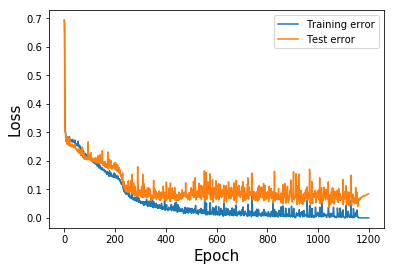

In [98]:
plt.plot(log_dic['epoch'], log_dic['loss'], label= 'Training error')
plt.plot(log_dic['epoch'], log_dic['loss_gen'], label= 'Test error')
plt.xlabel('Epoch', fontsize= 15)
plt.ylabel('Loss', fontsize= 15)
plt.legend()
plt.show()

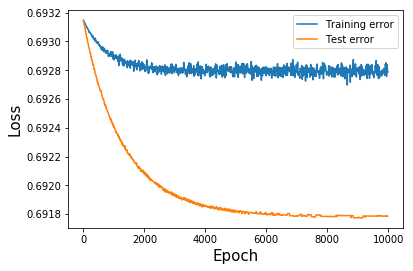

In [84]:
plt.plot(log_dic['epoch'][::10], log_dic['loss'][::10], label= 'Training error')
plt.plot(log_dic['epoch'][::10], log_dic['loss_gen'][::10], label= 'Test error')
plt.xlabel('Epoch', fontsize= 15)
plt.ylabel('Loss', fontsize= 15)
plt.legend()
plt.show()

### Take a look in what is stored in `log_dic`

Epoch number zero.

In [ ]:
log_dic['data'][0]

With `log_dic['data'][0]['activity']` we access activation values in the first epoch for each layer.

In [ ]:
log_dic['data'][0]['activity']

The first layer is `log_dic['data'][0]['activity'][0]`, the second `log_dic['data'][0]['activity'][1]` and so on. 

In [ ]:
log_dic['data'][0]['activity'][0]

The activation values for the last layers can be obtained without the knowledge about the number of layers.

In [ ]:
log_dic['data'][0]['activity'][-1]

### Writing Python dictionary to a file

In [99]:
save_obj(log_dic, 'tishby_mini_batch_artemy_1200')